# Brain Tumor Detection
## Resnet101 - Classifier + Regressor
Description
This dataset was originally created by Yousef Ghanem. To see the current project, which may have been updated since this version, please go here: https://universe.roboflow.com/yousef-ghanem-jzj4y/brain-tumor-detection-fpf1f.

This dataset is part of RF100, an Intel-sponsored initiative to create a new object detection benchmark for model generalizability.

Access the RF100 Github repo: https://github.com/roboflow-ai/roboflow-100-benchmark

## Imports

In [1]:
# Go to project root folder
import os
os.chdir("../")
%pwd

'/workspaces/brain-tumor-detection'

In [2]:
import numpy as np
from pathlib import Path
from dotenv import load_dotenv
load_dotenv()

import tensorflow as tf
tf.random.set_seed(42)

import matplotlib.pyplot as plt

2025-03-24 12:55:47.536115: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742820947.544270  276506 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742820947.546704  276506 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742820947.556356  276506 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742820947.556370  276506 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742820947.556372  276506 computation_placer.cc:177] computation placer alr

In [3]:
# Mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [4]:
found_gpu = tf.config.list_physical_devices('GPU')
if not found_gpu:
    raise Exception("No GPU found")
found_gpu, tf.__version__

([PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')], '2.19.0')

In [5]:
from src.data_handler.data_loader import DataLoader
from src.data_handler.annotation_processor import AnnotationProcessor
from src.data_handler.preprocessor import Preprocessor

In [6]:
# auto reload dotenv 
%load_ext dotenv
%dotenv

# auto reload libs
%load_ext autoreload
%autoreload 2

## Paths Setup

In [7]:
from hydra import initialize, compose

# https://gist.github.com/bdsaglam/586704a98336a0cf0a65a6e7c247d248

with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name="config")
    print(cfg.DATASET_DIRS.TRAIN_DIR)

datasets/-Brain-Tumor-Detection-2/train/


In [8]:
cfg.DATASET_DIRS

{'TRAIN_DIR': '${DATASET.DATASET_DIR}/${DATASET.DATASET_NAME}/train/', 'VALIDATION_DIR': '${DATASET.DATASET_DIR}/${DATASET.DATASET_NAME}/valid', 'TEST_DIR': '${DATASET.DATASET_DIR}/${DATASET.DATASET_NAME}/test'}

In [9]:
DATASET_DIRS = Path(cfg.DATASET.DATASET_DIR)
TRAIN_DIR = Path(cfg.DATASET_DIRS.TRAIN_DIR)
VALIDATION_DIR = Path(cfg.DATASET_DIRS.VALIDATION_DIR)
TEST_DIR = Path(cfg.DATASET_DIRS.TEST_DIR)
OUTPUT_DIR = Path(cfg.OUTPUTS.OUTPUT_DIR)

IMG_SIZE = cfg.TRAIN.IMG_SIZE
BATCH_SIZE = cfg.TRAIN.BATCH_SIZE
LOG_DIR = cfg.OUTPUTS.LOG_DIR
CHECK_POINT_DIR = Path(cfg.OUTPUTS.CHECKPOINT_PATH)
CLASS_NAME = [
    'label0',
    'label1',
    'label2'
]
class_map = {k: v for k, v in enumerate(CLASS_NAME)}

NUM_EPOCHS = cfg.TRAIN.NUM_EPOCHS
LEARNING_RATE = cfg.TRAIN.LEARNING_RATE

NUM_CLASSES = len(CLASS_NAME)

## Dataset Download from Roboflow

In [10]:
if not TRAIN_DIR.exists():
    from roboflow import Roboflow
    rf = Roboflow()
    project = rf.workspace("yousef-ghanem-jzj4y").project("brain-tumor-detection-fpf1f")
    version = project.version(2)
    dataset = version.download("tensorflow") 

## Load images from directory

In [11]:
prepare_train_dataset = AnnotationProcessor(annotation_file= str(TRAIN_DIR/'_annotations.csv'))
_class_map = {v: k for k, v in enumerate(CLASS_NAME)}
train_images, train_class_ids, train_bboxes  = prepare_train_dataset.process_annotations(image_dir=TRAIN_DIR, class_id_map=_class_map)

len(train_images), len(train_class_ids), len(train_bboxes)

(6851, 6851, 6851)

In [12]:
train_bboxes[0]

array([[0.68345324, 0.54545455, 0.95683453, 0.76515152],
       [0.42446043, 0.48484848, 0.99280576, 0.96969697],
       [0.46043165, 0.53030303, 0.99280576, 0.78030303]])

In [13]:
train_class_ids

[[0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1],
 [0, 1, 2],
 [0, 1, 2],
 [1, 2],
 [0, 1],
 [1],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [1, 2],
 [0, 1],
 [2],
 [1],
 [0, 1, 2],
 [1],
 [1],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [0, 1, 2],
 [1, 2],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [0, 1],
 [1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [0, 1, 2],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [1, 2],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1],
 [0, 1, 2],
 [1],
 [0, 1],
 [0, 1, 2],
 [1],
 [1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [1, 2],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [1],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2],
 [1],
 [0, 1, 2],
 [0, 1, 2],
 [0, 1, 2]

In [14]:
train_dl = DataLoader(train_images, train_class_ids, train_bboxes)
train_ds = train_dl.load_train_dataset()
train_ds = Preprocessor(train_ds).preprocess()
train_ds = train_ds.batch(BATCH_SIZE)\
                .prefetch(tf.data.AUTOTUNE)

I0000 00:00:1742820962.408381  276506 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7371 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:0a:00.0, compute capability: 8.6


In [15]:
for batch in train_ds.take(1):
    image, (cls, bbx) = batch
    print(image.shape, cls.shape, bbx.shape)
    print(cls[5])
    print(image[1].numpy().min(), image[1].numpy().max())
    for c in cls:
        print(c.numpy())

(32, 240, 240, 3) (32, 3) (32, 3, 4)
tf.Tensor([1. 1. 1.], shape=(3,), dtype=float32)
-123.7 151.0
[0. 1. 0.]
[0. 1. 0.]
[1. 1. 1.]
[1. 1. 1.]
[0. 1. 0.]
[1. 1. 1.]
[1. 1. 0.]
[1. 1. 1.]
[0. 1. 0.]
[1. 1. 1.]
[1. 1. 1.]
[1. 1. 1.]
[1. 1. 1.]
[0. 1. 0.]
[1. 1. 1.]
[1. 1. 1.]
[1. 1. 0.]
[0. 1. 0.]
[1. 1. 1.]
[0. 1. 0.]
[0. 1. 0.]
[1. 1. 1.]
[0. 1. 0.]
[1. 1. 1.]
[1. 1. 0.]
[0. 1. 0.]
[1. 1. 1.]
[1. 1. 1.]
[0. 1. 0.]
[1. 1. 1.]
[1. 1. 1.]
[0. 1. 0.]


2025-03-24 12:56:10.601099: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Validation datasets setup

In [16]:
prepare_valid_dataset = AnnotationProcessor(annotation_file= str(VALIDATION_DIR/'_annotations.csv'))

valid_image_paths, valid_class_ids, valid_bboxes  = prepare_valid_dataset.process_annotations(image_dir=VALIDATION_DIR, class_id_map=_class_map)
len(valid_image_paths), len(valid_class_ids), len(valid_bboxes)

(1963, 1963, 1963)

In [17]:
valid_dl = DataLoader(valid_image_paths, valid_class_ids, valid_bboxes).load_val_dataset()
valid_ds = Preprocessor(valid_dl).preprocess()
valid_ds = valid_ds.batch(BATCH_SIZE)\
                .prefetch(tf.data.AUTOTUNE)

In [18]:
for batch in valid_ds.take(1):
    image, (cls, bbx) = batch
    print(image.shape, cls.shape, bbx.shape)
    print(image[1].numpy().min(), image[1].numpy().max())

(32, 240, 240, 3) (32, 3) (32, 3, 4)
-123.68 138.49847


2025-03-24 12:56:11.904205: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Training Setup

## Define loss

In [19]:
padded_class_ids = train_dl.multi_hot_class_ids
padded_class_ids[:5]

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [0., 1., 0.]], dtype=float32)

In [20]:
from src.losses import binary_weighted_loss as _loss

positive_weights, negative_weights = _loss.compute_class_weights(padded_class_ids)
positive_weights, negative_weights 

(array([0.38140417, 0.01547219, 0.40767771]),
 array([0.61859584, 0.9845278 , 0.5923223 ], dtype=float32))

## Define ResNet50 Model

### Final Model

In [21]:
from src.losses import iou_loss
CLS_METRICS = [
    tf.keras.metrics.AUC(name='AUC', multi_label=True), 
    tf.keras.metrics.F1Score(name='f1_score',average='weighted')]


REG_METRICS = [
    iou_loss.iou_metric,
    tf.keras.metrics.MeanSquaredError(name='mse'),
    tf.keras.metrics.MeanAbsoluteError(name='mae')]

### Define  Callbacks

In [22]:
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import Schema, TensorSpec
# 1. Input Schema
# -----------------
# Your input is a batch of images with shape (32, 240, 240, 3)
# We use -1 to indicate that the batch size can vary.
input_schema = Schema([TensorSpec(np.dtype(np.float32), (-1, IMG_SIZE, IMG_SIZE, 3), "image")])

# 2. Output Schema - Multilabel binary classification head
# ------------------
# Your model outputs a list of two arrays. We need to define a schema for each.
# Array 1: Shape (1, 3)
output_schema_array1 = TensorSpec(np.dtype(np.float32), (-1, 3), "classification")

# Array 2: Shape (1, 3, 4) - 3 Bounding boxes per classification 
output_schema_array2 = TensorSpec(np.dtype(np.float32), (-1, 3, 4), "bounding_box")

# Create a schema for the list of outputs
output_schema = Schema([output_schema_array1, output_schema_array2])

# 3. Model Signature
# --------------------
# Combine the input and output schemas into a ModelSignature
signature = ModelSignature(inputs=input_schema, outputs=output_schema)

In [23]:
import os
import mlflow

mlflow_exp = mlflow.set_experiment("/brain-tumor-resnet101-phase-training")

### Define Optimizer

## Model Building and Compilation

In [24]:
class MultiTaskLoss(tf.keras.losses.Loss):
    def __init__(self, alpha=0.7, beta=0.3):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        
    def call(self, y_true, y_pred):
        cls_loss = _loss.set_binary_crossentropy_weighted_loss(
            positive_weights, negative_weights)(y_true[0], y_pred[0])
        box_loss = iou_loss.iou_loss(y_true[1], y_pred[1])
        return self.alpha * cls_loss + self.beta * box_loss

### Train and Validate the model

### Phase 1: Train feature extractor with classification head

In [25]:
to_monitor = 'val_bounding_box_iou_metric'
mode = 'min'
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, 
                                            patience=5, 
                                            monitor=to_monitor,
                                            mode=mode,
                                            min_lr=1e-7,
                                            verbose=1),

    tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(str(CHECK_POINT_DIR), "detector_ckpt_{epoch}.keras") ,
                                        save_weights_only=False,
                                        save_best_only=True,
                                        monitor=to_monitor,
                                        mode=mode,
                                        verbose=1),
                                        
    tf.keras.callbacks.EarlyStopping(monitor=to_monitor, 
                                    patience=10,
                                    mode=mode, 
                                    restore_best_weights=True,
                                    verbose=1),

    ]

In [26]:
run = mlflow.start_run() 
mlflow.tensorflow.autolog(log_models=True, 
                        log_datasets=False, 
                        log_input_examples=True,
                        log_model_signatures=True,
                        keras_model_kwargs={"save_format": "keras"},
                        checkpoint_monitor=to_monitor, 
                        checkpoint_mode=mode)

2025/03/24 12:56:14 WARNING mlflow.utils.autologging_utils: MLflow tensorflow autologging is known to be compatible with 2.7.4 <= tensorflow <= 2.18.0, but the installed version is 2.19.0. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a compatible version, or try upgrading MLflow.


In [27]:
from src.models.resnet101V2 import final_model

model = final_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES)

In [28]:
# Freeze regression branch and feature extractor
for layer in model.layers:
    if 'bounding_box' not in layer.name:
        layer.trainable = True
    else:
        print(layer.name)
        layer.trainable = False

bounding_box_conv2d_256
bounding_box_conv2d_256_2
bounding_box_reg_output
bounding_box


In [29]:
# Only enable classification training
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=3e-4),
    loss={'classification': _loss.set_binary_crossentropy_weighted_loss(positive_weights, negative_weights),
          'bounding_box':  iou_loss.iou_loss},
    metrics={'classification':  CLS_METRICS, 
             'bounding_box': [iou_loss.iou_metric]},
    loss_weights={'classification': 1.0, 'bounding_box': 0.0}
    )

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 240, 240,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 240, 240,  │          0 │ input_layer_1[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 246, 246,  │          0 │ cast[0][0]        │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 120, 120,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 122, 122,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 60, 60,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 60, 60,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 60, 60,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 60, 60,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 60, 60,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 60, 60,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 62, 62,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 60, 60,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 60, 60,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 60, 60,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 60, 60,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 60, 60,    │     16,640 │ conv2_block1_2_r

 Total params: 57,121,551 (217.90 MB)

 Trainable params: 51,708,803 (197.25 MB)

 Non-trainable params: 5,412,748 (20.65 MB)

In [30]:
to_monitor = 'val_classification_loss'
mode = 'min'
phase1_epoch = 30
history_ph1 = model.fit(
    train_ds,
    epochs=phase1_epoch,
    validation_data=valid_ds,
    batch_size=BATCH_SIZE,
    callbacks=[ 
        tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(str(CHECK_POINT_DIR), "phase1.weights.h5") ,
                                        save_weights_only=True,
                                        save_best_only=False,
                                        monitor=to_monitor,
                                        mode=mode,
                                        verbose=1),
        tf.keras.callbacks.EarlyStopping(monitor=to_monitor, 
                                    patience=3,
                                    mode=mode, 
                                    restore_best_weights=True,
                                    verbose=1),
            ])

Epoch 1/30


I0000 00:00:1742821021.771677  277441 service.cc:152] XLA service 0x753f74002000 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742821021.771726  277441 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-03-24 12:57:02.651555: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742821028.807493  277441 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1742821058.566262  277441 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - bounding_box_iou_metric: 4.5175e-04 - bounding_box_loss: 0.9995 - classification_AUC: 0.6364 - classification_f1_score: 0.4793 - classification_loss: 0.6486 - loss: 0.6940
Epoch 1: saving model to output/checkpoints/phase1.weights.h5


215/215 ━━━━━━━━━━━━━━━━━━━━ 142s 304ms/step - bounding_box_iou_metric: 4.5160e-04 - bounding_box_loss: 0.9995 - classification_AUC: 0.6367 - classification_f1_score: 0.4795 - classification_loss: 0.6485 - loss: 0.6938 - val_bounding_box_iou_metric: 3.0333e-04 - val_bounding_box_loss: 0.9997 - val_classification_AUC: 0.6508 - val_classification_f1_score: 0.2563 - val_classification_loss: 1.9919 - val_loss: 2.0005
Epoch 2/30
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - bounding_box_iou_metric: 2.4832e-04 - bounding_box_loss: 0.9998 - classification_AUC: 0.7638 - classification_f1_score: 0.5333 - classification_loss: 0.5522 - loss: 0.5707
Epoch 2: saving model to output/checkpoints/phase1.weights.h5
215/215 ━━━━━━━━━━━━━━━━━━━━ 30s 104ms/step - bounding_box_iou_metric: 2.4874e-04 - bounding_box_loss: 0.9998 - classification_AUC: 0.7638 - classification_f1_score: 0.5333 - classification_loss: 0.5521 - loss: 0.5706 - val_bounding_box_iou_metric: 4.7911e-04 - val_bounding_box_loss: 0.9995 - 

215/215 ━━━━━━━━━━━━━━━━━━━━ 31s 112ms/step - bounding_box_iou_metric: 5.1269e-04 - bounding_box_loss: 0.9995 - classification_AUC: 0.8821 - classification_f1_score: 0.6053 - classification_loss: 0.3400 - loss: 0.3468 - val_bounding_box_iou_metric: 1.4640e-04 - val_bounding_box_loss: 0.9999 - val_classification_AUC: 0.8222 - val_classification_f1_score: 0.3978 - val_classification_loss: 0.5846 - val_loss: 0.5897
Epoch 6/30
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - bounding_box_iou_metric: 4.1571e-04 - bounding_box_loss: 0.9996 - classification_AUC: 0.8986 - classification_f1_score: 0.6058 - classification_loss: 0.3397 - loss: 0.3457
Epoch 6: saving model to output/checkpoints/phase1.weights.h5
215/215 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - bounding_box_iou_metric: 4.1695e-04 - bounding_box_loss: 0.9996 - classification_AUC: 0.8987 - classification_f1_score: 0.6058 - classification_loss: 0.3396 - loss: 0.3455 - val_bounding_box_iou_metric: 2.6614e-04 - val_bounding_box_loss: 0.9997 - v

2025/03/24 13:04:54 WARNING mlflow.models.signature: Failed to infer schema for outputs. Setting schema to `Schema([ColSpec(type=AnyType())]` as default. To see the full traceback, set logging level to DEBUG.
2025/03/24 13:05:09 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp92lx49ef/model, flavor: tensorflow). Fall back to return ['tensorflow==2.19.0', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/03/24 13:05:09 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


### Phase 2: Freeze classification head and train bounding box head

In [31]:
# Switch trainable components
for layer in model.layers:
    layer.trainable = False  # Freeze all first
    if  ('conv4_block3' in layer.name) or ('conv5_block3' in layer.name) or ('bounding_box' in layer.name):
        print(layer.name)
        layer.trainable = True  

conv4_block3_preact_bn
conv4_block3_preact_relu
conv4_block3_1_conv
conv4_block3_1_bn
conv4_block3_1_relu
conv4_block3_2_pad
conv4_block3_2_conv
conv4_block3_2_bn
conv4_block3_2_relu
conv4_block3_3_conv
conv4_block3_out
conv5_block3_preact_bn
conv5_block3_preact_relu
conv5_block3_1_conv
conv5_block3_1_bn
conv5_block3_1_relu
conv5_block3_2_pad
conv5_block3_2_conv
conv5_block3_2_bn
conv5_block3_2_relu
conv5_block3_3_conv
conv5_block3_out
bounding_box_conv2d_256
bounding_box_conv2d_256_2
bounding_box_reg_output
bounding_box


In [32]:
model.compile(
    optimizer=tf.keras.optimizers.AdamW(1e-4),
    loss={'classification': _loss.set_binary_crossentropy_weighted_loss(positive_weights, negative_weights),
          'bounding_box':  iou_loss.iou_loss},
    metrics={'classification': [tf.keras.metrics.F1Score(name='f1_score',average='weighted')], 
             'bounding_box': REG_METRICS},
    loss_weights={'classification': 0.0, 'bounding_box': 1.0})

In [33]:
# Set the number of epochs for fine-tuning
to_monitor = 'val_bounding_box_iou_metric'
mode = 'max'
phase2_epoch = phase1_epoch + 70 

history_ph2 = model.fit(
    train_ds,
    epochs=phase2_epoch,
    initial_epoch=history_ph1.epoch[-1],  # Start from the last epoch of initial training
    validation_data=valid_ds,
    batch_size=BATCH_SIZE,
    callbacks=[ 
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, 
                                            patience=5, 
                                            monitor=to_monitor,
                                            mode=mode,
                                            min_lr=1e-7,
                                            verbose=1),
        tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(str(CHECK_POINT_DIR), "phase2.weights.h5") ,
                                        save_weights_only=True,
                                        save_best_only=False,
                                        monitor=to_monitor,
                                        mode=mode,
                                        verbose=1),
        tf.keras.callbacks.EarlyStopping(monitor=to_monitor, 
                                    patience=5,
                                    mode=mode, 
                                    restore_best_weights=True,
                                    verbose=1),])

Epoch 13/100
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - bounding_box_iou_metric: 0.0179 - bounding_box_loss: 0.9821 - bounding_box_mae: 0.8295 - bounding_box_mse: 1.3535 - classification_f1_score: 0.6499 - classification_loss: 0.1074 - loss: 0.9821
Epoch 13: saving model to output/checkpoints/phase2.weights.h5
215/215 ━━━━━━━━━━━━━━━━━━━━ 52s 132ms/step - bounding_box_iou_metric: 0.0181 - bounding_box_loss: 0.9819 - bounding_box_mae: 0.8286 - bounding_box_mse: 1.3514 - classification_f1_score: 0.6498 - classification_loss: 0.1076 - loss: 0.9819 - val_bounding_box_iou_metric: 0.1502 - val_bounding_box_loss: 0.8510 - val_bounding_box_mae: 0.3311 - val_bounding_box_mse: 0.2010 - val_classification_f1_score: 0.5906 - val_classification_loss: 0.5109 - val_loss: 0.8502 - learning_rate: 1.0000e-04
Epoch 14/100
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - bounding_box_iou_metric: 0.2013 - bounding_box_loss: 0.7994 - bounding_box_mae: 0.2794 - bounding_box_mse: 0.1467 - classification_f1_score:

2025/03/24 13:19:06 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: Changing param values is not allowed. Param with key='epochs' was already logged with value='30' for run ID='8e608994944f4f308d0f2ac47a489c15'. Attempted logging new value '100'.


### Phase 3: Fine-tune entire model with reduced learning rate

In [34]:
# Unfreeze all layers except first 150
for layer in model.layers[:150]:
    layer.trainable = False
for layer in model.layers[150:]:
    layer.trainable = True

In [36]:
model.compile(
    optimizer=tf.keras.optimizers.AdamW( learning_rate=1e-5, 
    clipnorm=1.0  # Essential for stable training
    ),
    loss={'classification': _loss.set_binary_crossentropy_weighted_loss(positive_weights, negative_weights),
          'bounding_box':  iou_loss.iou_loss},
    metrics={'classification': CLS_METRICS, 'bounding_box': REG_METRICS},
    # Train with 0 weight for classification
    loss_weights={'classification': 0.1,  'bounding_box': 0.9 } )

In [37]:
phase3_epoch = phase2_epoch + 70 

history = model.fit(
    train_ds,
    epochs=phase3_epoch,
    initial_epoch=history_ph2.epoch[-1],  # Start from the last epoch of initial training
    validation_data=valid_ds,
    batch_size=BATCH_SIZE,
    callbacks=[callbacks])

Epoch 49/170
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - bounding_box_iou_metric: 0.4030 - bounding_box_loss: 0.5977 - bounding_box_mae: 0.1909 - bounding_box_mse: 0.0872 - classification_AUC: 0.9156 - classification_f1_score: 0.6306 - classification_loss: 0.1431 - loss: 0.5573
Epoch 49: val_bounding_box_iou_metric improved from inf to 0.40789, saving model to output/checkpoints/detector_ckpt_49.keras
215/215 ━━━━━━━━━━━━━━━━━━━━ 106s 224ms/step - bounding_box_iou_metric: 0.4031 - bounding_box_loss: 0.5976 - bounding_box_mae: 0.1909 - bounding_box_mse: 0.0872 - classification_AUC: 0.9157 - classification_f1_score: 0.6305 - classification_loss: 0.1431 - loss: 0.5572 - val_bounding_box_iou_metric: 0.4079 - val_bounding_box_loss: 0.5939 - val_bounding_box_mae: 0.1902 - val_bounding_box_mse: 0.0857 - val_classification_AUC: 0.8470 - val_classification_f1_score: 0.5890 - val_classification_loss: 0.4281 - val_loss: 0.5814 - learning_rate: 1.0000e-05
Epoch 50/170
214/215 ━━━━━━━━━━━━━━━━━━━━

2025/03/24 13:25:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: Changing param values is not allowed. Param with key='epochs' was already logged with value='30' for run ID='8e608994944f4f308d0f2ac47a489c15'. Attempted logging new value '170'.


In [38]:
model_uri: str = "runs:/{}/model".format(run.info.run_id)
loaded_model = mlflow.tensorflow.load_model(model_uri)

loaded_model.evaluate(valid_ds, return_dict=True)

/code/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 356 variables whereas the saved optimizer has 706 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/code/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 352 variables whereas the saved optimizer has 702 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 93ms/step - bounding_box_iou_metric: 7.8389e-04 - bounding_box_loss: 0.9992 - classification_AUC: 0.8830 - classification_f1_score: 0.6175 - classification_loss: 0.4686 - loss: 0.4737


{'bounding_box_iou_metric': 0.0007094563916325569,
 'bounding_box_loss': 0.9993076920509338,
 'classification_AUC': 0.8959500193595886,
 'classification_f1_score': 0.6229265332221985,
 'classification_loss': 0.48787543177604675,
 'loss': 0.49386468529701233}

## Model Evaluation

### Testing Datasets setup

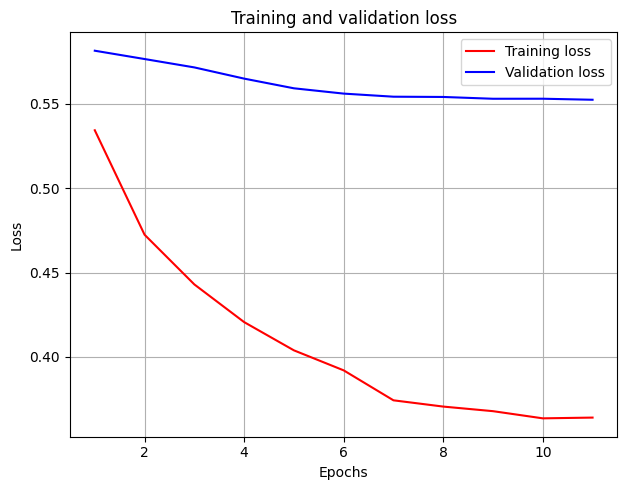

In [39]:
from src.utils.visualization_funcs import visualize_training_results


visualize_training_results(history.history)

In [40]:
prepare_test_dataset = AnnotationProcessor(annotation_file= str(TEST_DIR/'_annotations.csv'))
_class_map = {v: k for k, v in enumerate(CLASS_NAME)}
test_image_paths, test_class_ids, test_bboxes = prepare_test_dataset.process_annotations(image_dir=TEST_DIR, class_id_map=_class_map)

len(test_image_paths), len(test_class_ids), len(test_bboxes)

(973, 973, 973)

In [41]:
test_dl = DataLoader(test_image_paths, test_class_ids, test_bboxes, img_size=IMG_SIZE)
test_ds = test_dl.load_val_dataset()
y_true_labels = test_dl.multi_hot_class_ids
y_true_bboxes = test_dl.padded_bbx
test_ds = Preprocessor(test_ds).preprocess()
test_ds = test_ds.batch(BATCH_SIZE)\
                .prefetch(tf.data.AUTOTUNE)

In [42]:
results = model.evaluate(test_ds, return_dict=True, steps=1)
results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - bounding_box_iou_metric: 0.4041 - bounding_box_loss: 0.5959 - bounding_box_mae: 0.2072 - bounding_box_mse: 0.0959 - classification_AUC: 0.6093 - classification_f1_score: 0.6306 - classification_loss: 0.3501 - loss: 0.5763


{'bounding_box_iou_metric': 0.4041292071342468,
 'bounding_box_loss': 0.595870852470398,
 'bounding_box_mae': 0.20716187357902527,
 'bounding_box_mse': 0.09592722356319427,
 'classification_AUC': 0.6093355417251587,
 'classification_f1_score': 0.6305853128433228,
 'classification_loss': 0.3501078486442566,
 'loss': 0.5762627720832825}

In [43]:
from sklearn.metrics import classification_report

y_prob_pred, pred_bbx = model.predict(test_ds)
y_prob_pred[0], pred_bbx[0]

31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 201ms/step


(array([0.833 , 0.707 , 0.7705], dtype=float16),
 array([[0.546 , 0.7246, 0.831 , 0.9316],
        [0.3457, 0.6455, 0.98  , 1.099 ],
        [0.529 , 0.6655, 0.835 , 0.949 ]], dtype=float16))

In [44]:
y_pred = (y_prob_pred>0.5).astype(int)
y_pred[:5]

array([[1, 1, 1],
       [0, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [0, 1, 1]])

In [45]:
report = classification_report(y_true_labels, y_pred, labels=[0,1,2], target_names=CLASS_NAME)
print(report)

              precision    recall  f1-score   support

      label0       0.89      0.81      0.85       588
      label1       0.99      0.92      0.95       962
      label2       0.87      0.82      0.85       554

   micro avg       0.93      0.86      0.90      2104
   macro avg       0.92      0.85      0.88      2104
weighted avg       0.93      0.86      0.90      2104
 samples avg       0.93      0.87      0.88      2104



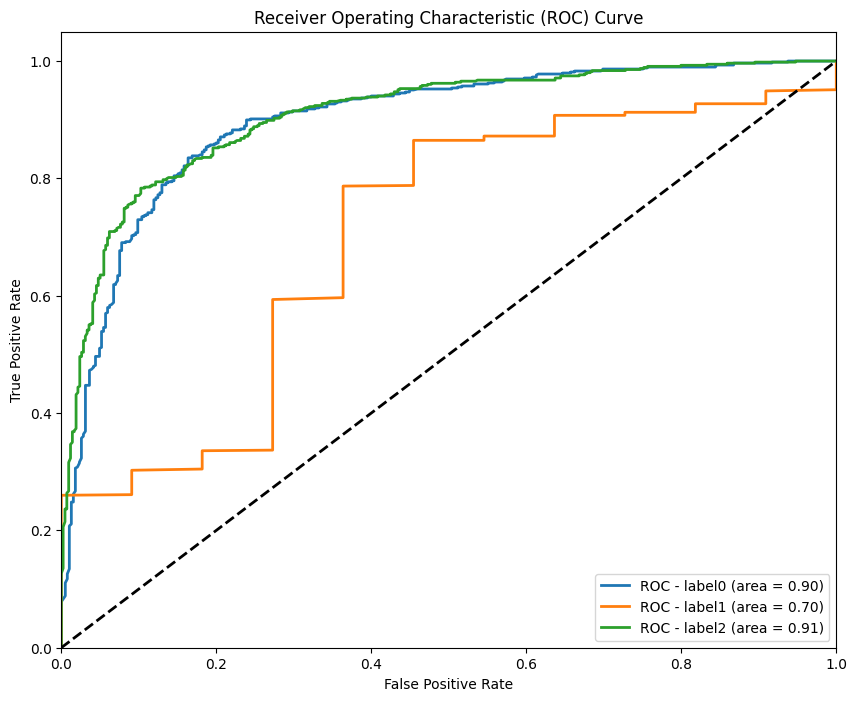

In [46]:
from src.utils.visualization_funcs import plot_auc_curve

plot_auc_curve(OUTPUT_DIR, CLASS_NAME, y_true_labels, y_prob_pred)

In [47]:
test_bboxes[:2], '---------------------------------------', pred_bbx[:2]

([array([[0.61151079, 0.65909091, 0.75539568, 0.82575758],
         [0.36690647, 0.58333333, 0.85611511, 0.98484848],
         [0.58992806, 0.66666667, 0.78417266, 0.84090909]]),
  array([[0.61151079, 0.09848485, 0.99280576, 0.4469697 ]])],
 '---------------------------------------',
 array([[[0.546  , 0.7246 , 0.831  , 0.9316 ],
         [0.3457 , 0.6455 , 0.98   , 1.099  ],
         [0.529  , 0.6655 , 0.835  , 0.949  ]],
 
        [[0.541  , 0.0636 , 0.887  , 0.3716 ],
         [0.583  , 0.02118, 0.925  , 0.3796 ],
         [0.5957 , 0.0885 , 0.8647 , 0.3147 ]]], dtype=float16))

In [48]:
from src.losses.iou_loss import iou_metric
def plot_iou_histogram(y_true_bbox, y_pred_bbox, class_ids):
    """
    Plots a histogram of Intersection over Union (IoU) scores.

    Args:
        y_true_bbox: Ground truth bounding boxes (list of lists or numpy array).
        y_pred_bbox: Predicted bounding boxes (list of lists or numpy array).
        class_ids: list of class ids.
    """
    fig, axs = plt.subplots(1)

    iou_scores = iou_metric(y_true_bbox, y_pred_bbox)

    # fig.figure(figsize=(10, 6))
    axs.hist(iou_scores, bins=20, range=(0, 1), edgecolor='black')
    axs.set_title('IoU Score Distribution')
    axs.set_xlabel('IoU Score')
    axs.set_ylabel('Frequency')
    axs.grid(True)
    plt.show()
    plt.savefig(f"{OUTPUT_DIR}/iou_histogram.png")
    return fig


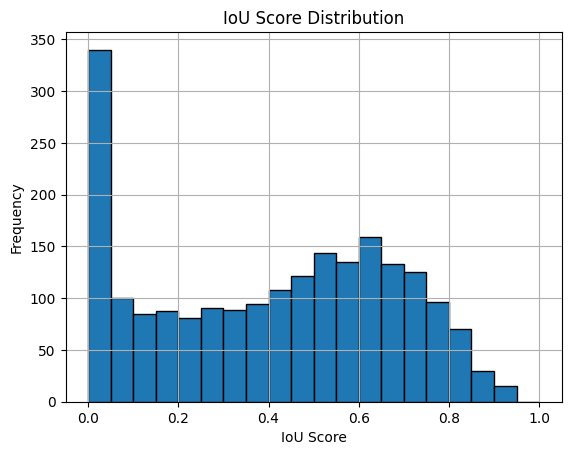

<Figure size 640x480 with 0 Axes>

In [49]:
fig = plot_iou_histogram(y_true_bboxes, pred_bbx, pred_bbx)
mlflow.log_figure(fig, 'iou_histogram.png')